In [1]:
import mdtraj
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Part 1
xtal_data = mdtraj.load('./Inputs/NC13_RNA_ATP/7nio.pdb')
alpha_0_data = mdtraj.load('./Inputs/NC13_RNA_ATP/fold_nc13_rna_atp/fold_nc13_rna_1atp_model_0.pdb')

/ext3/miniconda3/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [3]:
align_data = alpha_0_data.superpose(xtal_data, atom_indices=alpha_0_data.topology.select('name CA'))
# align_data.save_pdb('./Inputs/NC13_RNA_ATP/aligned_model_0.pdb')

In [8]:
topology = alpha_0_data.topology
rna_phos_atoms = topology.select('element P and resname U')
uracil_ox_atoms = topology.select('(resname U and name O2) or (resname U and name O4)')
protein_atoms = topology.select('protein')
cutoff = 0.5 # nm

In [9]:
rna_phos_nearby = mdtraj.compute_neighbors(alpha_0_data, cutoff, rna_phos_atoms, haystack_indices=protein_atoms)

residues = set()
for atom_idx in rna_phos_nearby[0]:
    residue = topology.atom(atom_idx).residue
    residues.add(residue.name)
# print(list(sorted(residues)))

# primarily polar (and positively charged) residues nearby which is expected as
# the phosphate backbone is negatively charged
# suprisingly there is a nearby ASP, which is negatively charged and 
# hydrophobic valine and tyrosine

In [10]:
uracil_ox_nearby = mdtraj.compute_neighbors(alpha_0_data, cutoff, uracil_ox_atoms, haystack_indices=protein_atoms)

residues = set()
for atom_idx in uracil_ox_nearby[0]:
    residue = topology.atom(atom_idx).residue
    residues.add(residue.name)
# print(list(sorted(residues)))

# we would expect amino acids that readily form h-bonds and are polar as
# these would have the strongest interactions and for the most part what we see
# there is however also hydrophobic side chains like leucine, methionine, and valine

In [11]:
# Part 2
alpha2_data = mdtraj.load('./Inputs/Actin_Profilin/actin_profilin_af2_colab/actin_profilin_923b1/actin_profilin_923b1_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb')
alpha3_data = mdtraj.load('./Inputs/Actin_Profilin/actin_profilin_adp_af3/fold_actin_profilin_adp_model_0.pdb')

In [12]:
# get chains and adjust
alpha2_chainA = alpha2_data.atom_slice(alpha2_data.topology.select('chainid 0'))  
alpha3_chainA = alpha3_data.atom_slice(alpha3_data.topology.select('chainid 0')) 
alpha3_chainA = alpha3_chainA.atom_slice([i for i in range(alpha3_chainA.n_atoms - 1)])

# need to fix mappings
atom_map = {(atom.name, atom.residue.index): atom.index for atom in alpha2_chainA.topology.atoms}
reordered_coordinates = np.empty((alpha2_chainA.n_frames, 2916, 3), dtype=np.float32)
i = 0
for atom in alpha3_chainA.topology.atoms:
    key = (atom.name, atom.residue.index)
    if i != atom.index:
        print(i)
    i += 1
    if key in atom_map:
        alpha2_index = atom_map[key]
        reordered_coordinates[:, atom.index, :] = alpha2_chainA.xyz[:, alpha2_index, :]

reorder_alpha2_chainA = mdtraj.Trajectory(xyz=reordered_coordinates, topology=alpha3_chainA.topology)

# alignment 
align_alpha3_chainA = alpha3_chainA.superpose(reorder_alpha2_chainA, atom_indices=reorder_alpha2_chainA.topology.select('all'))                                        

In [13]:
# compute distances by atom
n_atoms = align_alpha3_chainA.n_atoms
combined_chainA = align_alpha3_chainA.stack(reorder_alpha2_chainA)
pairs = [[i, i + n_atoms] for i in range(n_atoms)]
distances = mdtraj.compute_distances(combined_chainA, atom_pairs=pairs, periodic=True)[0]

In [14]:
# get per residue
n_residues = align_alpha3_chainA.n_residues
residue_distances = [0] * n_residues 
for i in range(n_atoms):
    # Get residues for the two atoms
    residue_id = align_alpha3_chainA.topology.atom(i).residue.index
    
    # Add the computed distance (summed over all frames)
    residue_distances[residue_id] += distances[i]

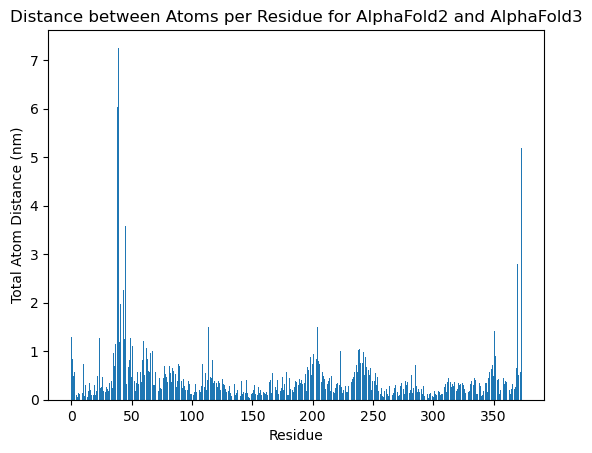

In [15]:
plt.bar([i for i in range(n_residues)], residue_distances)
plt.xlabel('Residue')
plt.ylabel('Total Atom Distance (nm)')
plt.title('Distance between Atoms per Residue for AlphaFold2 and AlphaFold3')
plt.savefig('./Figures/residue_dist_alpha2_alpha3.png')
plt.show()
# The floppier regions (e.g. loops) have greater differences between them

In [17]:
import glob 
file_path = './Inputs/1V1D/1v1d_5c7bb/1v1d_5c7bb_unrelaxed_rank_0'
models = ['1', '2', '3', '4', '5']
alpha_datas = []
matches = []
for i in range(1, 41):
    if i < 10:
        file_path_rank = file_path + '0' + str(i) + '_alphafold2_ptm_model_'
    else:
        file_path_rank = file_path + str(i) + '_alphafold2_ptm_model_'
    for model in models:
        file_path_search = file_path_rank + model + '*'
        matched_files = glob.glob(file_path_search)
        if len(matched_files) != 0:
            matches.append(i)
            alpha_data = mdtraj.load(matched_files[0])  
            alpha_datas.append(alpha_data)
            break

In [18]:
n_atoms = alpha_datas[0].n_atoms
pairs = [[i, i + n_atoms] for i in range(n_atoms)]
distances = []
for i in range(0, 39):
    aligned_i = alpha_datas[i + 1].superpose(alpha_datas[0], atom_indices= alpha_datas[0].topology.select('name CA'))
    combined_0_i = aligned_i.stack(alpha_datas[0])
    distances.append(mdtraj.compute_distances(combined_0_i, atom_pairs=pairs, periodic=True)[0])

In [19]:
# get per residue
n_residues = alpha_datas[0].n_residues
residue_distances = [[0 for i in range(n_residues)] for j in range(len(distances))]
slices = [[] for i in range(n_residues)]
for j in range(n_atoms):
    # Get residues for the two atoms
    residue_id = alpha_datas[0].topology.atom(j).residue.index
    slices[residue_id].append(j)
for i in range(len(distances)):
        # Add the computed distance (summed over all frames)
    for k in range(n_residues):
        residue_distances[i][k] += sum(distances[i][slices[k]])

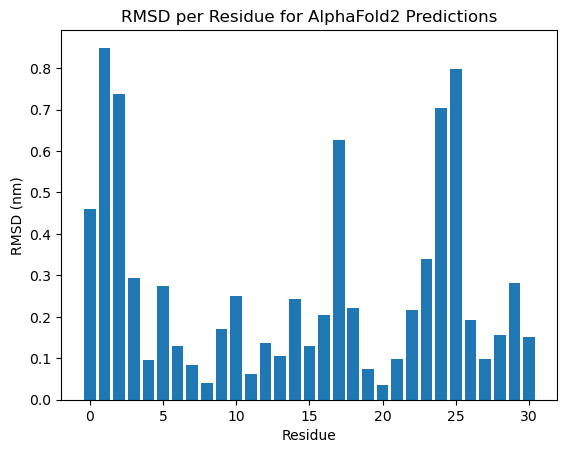

In [20]:
rmsd_residue_distances = np.std(residue_distances, axis = 0)
plt.bar([i for i in range(n_residues)], rmsd_residue_distances)
plt.xlabel('Residue')
plt.ylabel('RMSD (nm)')
plt.title('RMSD per Residue for AlphaFold2 Predictions')
plt.savefig('./Figures/residue_dist_1v1d.png')
plt.show()
# The floppier regions (e.g. loops) have greater differences between them